<h1><center> STA663 Statistical Computation Final Project </center></h1>
<h2><center> Implementatiton of Latent Dirichlet Allocation(LDA) </center></h2>
<h3><center> Hengqian Zhang, Mengrui Yin </center></h3>

https://github.com/zhanghe7/stat663HZ-MY.git

## Summary

$\quad$Latent Dirichlet Allocation is a generative probabilistic model to deal with discrete data such as text corpora. In this report, we implemented the algorithm in the paper ”Latent Dirichlet Allocation”(David M. Blei, Andrew Y.Ng, Michael I. Jordan) with Gibbs Sampler and Variatioanl Inference, compared results of these two methods, performed code testing to ensure correctness and optimized the Python code with Cython to make our work faster. Simulation is used for generating small text set to do inference. 

### 1  Introduction

$\quad$The paper we selected is "Latent Dirichlet Allocation"(David M. Blei, Andrew Y. Ng, Michael I. Jordan). One of our homework about tf-idf scheme intrigued our interests about text modeling, so we selected this paper to implement. tf-idf did not concern latent relationships between words. The situation of two documents with few common words but are similar cannot be analyzed by tf-idf. So LDA did great improvement. It is much more complex than tf-idf with better performance. It is a three level hierarchical Bayesian model including words, topics, documents. Text corpora is a collection of documents and each document is a mixture distributions over topics. Each topic is a mixture distribution over words under this topic. Due to difficulty of computation, LDA applied variational methods and an EM algorithm for parameter estimates and inference.<br> 
$\quad$ The alternative method to deal with compuation difficulty is Gibbs Sampler. LDA is an unsupervised machine learning algorithm, which is used to recognize latent topics of big dataset of text such as corpus. It is a powerful tool for text data set. It can be used for document modeling,classification and filtering. In LDA algorithm, words in all doucuments are regarded as a VOCABULARY and we regard VOCABULARY as word bag, which is no order between words. So, LDA simplifies complexity of topic inference. In our project, we implemented LDA algorithm and applied it on texts to find top words of each topics.  

### 2 Algorithm Description

#### 2.1 define terms

* A **word** is defined as a item from a VOCABULARY with index
$\{$1$\cdots$V$\}$<br>
* A **document** is a sequence of N words denoted by $\vec{w}$ = $\{$ w$_1$,w$_2$ $\cdots$ w$_N$ $\}$,where w$_n$ is the nth word of the document <br>
* A **corpus** is a collection of M documents denoted by $D = { \vec{w_1},\vec{w_2} \cdots \vec{w_M} }$, where $\vec{w_m}$ represents document m


LDA assumes the following generative process for each document
$\vec{w}$ in a corpus D:
1. Choose N $\sim$ Poisson($\xi$)
2. Choose $\vec{\theta}$ $\sim$ Dir($\vec{\alpha}$)
3. For each of the N words w$_n$:<br>
(a) Choose a topic z$_n$ $\sim$ Multinomial($\vec{\theta}$)<br> 
(b) Choose a word w$_n$ from p(w$_n$ $|$ z$_n$,$\vec{\beta}$), a Multinomial probability conditioned on the topic z$_n$<br>

* N: the number of words in a document <br> 
* K: the number of topics <br> 
* $\vec{\alpha}$: a vector with k dimension, hyper-parameter of distribution of document-topic <br>
* $\vec{\beta}$: a matrix, a distribution of topic-word<br>
* $\vec{\theta}$: the vector of ${p(z_n | d)}$ with K dimension, d denotes the document. $\vec{\theta}$ can be denoted  as $\{p_{t1} \cdots p_{tk}\}$, where p$_{ti}$ represents the probability of topic i in the document d. $\theta_m$ is the topic distribution of document m<br>
* z$_n$: the index of topic of nth word in the document<br>
* w$_n$: the index of nth word<br>

The following shows the process of LDA<br>
<br>
![caption](files/LDA.png)

$\quad$The graphs above shows the process of LDA. The outer frame is corpus which is made up of M single document. The inner frame has tow components: words(circle w) and topics(circle z). The graph clearly demonstrate the process of LDA. $\alpha$ is parameter of $\theta$. $\theta$ is a  distribution of document-topic whose prior is Dirichlet Distribution. Topic z is sampled from a mixture distribution over topics, so it is sampled for multinomial($\theta$). After obtaining topic, we can find distribution of words under this topic and sampled word form this distribution. $\beta$ is parameter of word distribution.  

#### 2.2 derive the model

$\quad$As above, $\vec{\theta}$ $\sim$ Dir($\vec{\alpha}$), so<br>
<center>$p(\vec{\theta}|\vec{\alpha})$ = $\frac{\Gamma(\sum_{i=1}^{k}\alpha_i)}{\prod_{i=1}^{k}\Gamma(\alpha_i)}\theta_1^{\alpha_1-1} \cdots \theta_k^{\alpha_k-1}$<br>

$\quad$$\vec{\theta}$ is sampled from Dirichlet Distribution.The reason to use Dirichlet because it will focus on only important words of a document. Thinking one word as a feature, if we only focus on important words, the features could be decreased and thus the dimension will be decreased. So LDA select Dirichlet as prior of $\vec{\theta}$ can achieve dimension reduction.<br>
<br>
$\quad$Given the parameters $\alpha$ and $\beta$, the joint distribution of a topic mixture $\vec{\theta}$, a set of N topics $\vec{z}$ and a set of N words $\vec{w}$ is given by:<br>
<center>p($\theta$,$\vec{z}$,$\vec{w}$ $|$ $\alpha$,$\beta$) = p($\theta$ $|$ $\alpha$)
$\prod_{n=1}^{N}$ p(z$_n$ $|$ $\theta$)p(w$_n$ $|$z$_n$,$\beta$)<center>
<br>

$\quad$Intergrating over $\vec{\theta}$ and summing over z, we obtain the marginal distribution of a document:<br>
<br>
<center>$p(\vec{w} | \alpha,\beta) =\int p(\theta | \alpha) (\prod_{n=1}^{N} \sum_{z_n} p(z_n | \theta)p(w_n |z_n,\beta))d\theta$<center><br>

$\quad$Finally, taking the product of the marginal probabilities of single documents, we obtian the probability of a corpus:<br>
<br>
<center>$p(D | \alpha,\beta) =\prod_{d=1}^{M}\int p(\theta_d | \alpha) (\prod_{n=1}^{N_d} \sum_{z_{dn}} p(z_{dn} | \theta_d)p(w_{dn} | z_{dn},\beta))d\theta_d$<center><br>

#### 2.3 Inference

$\quad$The key inferential problem that we need to solve in orde to use LDA is that of computing the posterior distribution of the hidden variables given a document:<br>
<center>p($\vec{\theta}$,$\vec{z}$ $|$ $\vec{w}$,$\alpha$,$\beta$) = $\frac{p(\vec{\theta},\vec{z},\vec{w} | \alpha,\beta)}{p(\vec{w} | \alpha,\beta)}$<center><br>

Likelihood:<br>
<center>p($\vec{w}$ $|$ $\alpha$,$\beta$) = $\frac{\Gamma(\sum_{i}\alpha_i)}{\prod_i\Gamma(\alpha_i)}\int(\prod_{i=1}^{k}\theta_i^{\alpha_i-1})(\prod_{n=1}^{N}\sum_{i=1}^{k}\prod_{j=1}^{V}(\theta_i\beta_{ij})^{w_n^j})d\theta$<center><br>

$\quad$However, this function is not intractable due to the product of $\theta_i$ 
and 
$\beta_{ij}$
in the summation over latent variable. So we use Gibbs Sampler to get approximated distribtuion. The alternative solution is using Variational Inference in EM algorithm to get the approximation of posterior of latent variables

### 3 Gibbs Sampler Implementation

$\quad$We use Monte Carlo Markov Chain(Gibbs Sampler) to get approximated distribution. We have parameters $\theta$
,$\phi$ and z. Through Gibbs Sampler, instead of updating these three parameters, we only need to update z since we can removing parameter $\theta$ and $\phi$ by integrating over them. Then we use z to update $\theta$ and $\phi$.($\phi$ here is differnet from $\phi$ in Variational Inference. In Variational Inference, $\phi$ is latent parameter for topics vector $\vec{z}$).

$\quad$We apply Gibbs Sampler to get full conditional distribution $p(z_i|\vec{z}_{-i},\vec{w})$, which is an approximation of $p(\vec{z}|\vec{w})$<br>.
$\quad$To find full conditionals, we focus on joint distribution first.<br>
Joint distribution: <br>
<center>$p(\vec{w},\vec{z}|\vec{\alpha},\vec{\beta})p(\vec{z}|\vec{w}) = p(\vec{w}|\vec{z},\vec{\beta})p(\vec{z}|\vec{\alpha})$<center><br>

$\quad$The first term does not contain $\alpha$ and the second term does not contain $\beta$,so we can deal with them separately,<br>
<center>$p(\vec{w}|\vec{z},\vec{\phi}) = \prod_{i=1}^{w}p(w_i|z_i) = \prod_{i=1}^{w}\varphi_{z_i,w_i}$<center>
<br>
<br>
$p(\vec{w}|\vec{z},\vec{\phi}) = 
\prod_{k=1}^{K}\prod_{i:z_i:=k}p(w_i = t|z_i = k) = \prod_{k=1}^{K}\prod_{t=1}^{V}\varphi_{k,t}^{{n_k}^{(t)}}$

* w:represents the total words in Corpus<br>
* ${n_k}^{(t)}$ represents the number of times word t is observed in topic k.
Our goal
$p(\vec{w}|\vec{z},\vec{\beta})$ is obtained by integrating over 
$\phi$.
$\phi$ is assumed as a known parameter: a matrix with K $\times$ V dimension. Every entry is the probability of a word under each topic. So each row is one topic and each column is one word.<br>
<br>
The we integrate over $\phi$ and we can derive:<br>
<center>$P(\vec{w}|\vec{z},\vec{\beta}) = \int P(\vec{w} |\vec{z},\phi) P(\phi|\vec{\beta}) d\phi$\\
$= \int \prod_{k=1}^{K}\frac{1}{\Delta \vec{beta}}\prod_{t+1}{V}\varphi_{k,t}^{{n_k}^{(t)}+\beta_t-1} d\varphi_k$<br>
$= \prod_{i=1}^{K}\frac{\Delta(\vec{n_k}+\vec{\beta})}{\Delta(\vec{\beta})}$,
$\vec{n_k} = \{{n_k}^{(t)}\}_{t=1}^{V}$<br><center>

* The vector
$\vec{n}_k$ represents the ditribution of words under topic k, it can be denoted as
$\vec{n}_k$
= (the number of word 1 under topic k, the number of word 2 under topic k $\cdots$).<br>
<br>
After calculation and simplification, we can get full conditionals:<br>
<center>p$(z_i = k|\vec{z}_{-i},\vec{w}) = \frac{p(\vec{w},\vec{z})}{p(\vec{w},\vec{z}_{-i})} = \frac{n_i-1 + \beta_i}{\sum_{t=1}^{V}(n_{t,-i}+\beta_t)}\frac{n_k-1+\alpha_k}{\sum_{t=1}{K}(n_{t,-i}+\alpha_t)}$<br><center>

* $n_i-1$
:the number of word i in topic k -1<br>
* $p(\vec{w},\vec{z}_{-i})$
: the probability of word i is from topic k<br>
* $n_k-1$
: the number of topic under document m -1<br>
* $\sum_{t=1}{K}(n_{t,-i}+\alpha_t)$
: the probability of topic k is from document m<br>

$\quad$Then we use full conditionals to update $\theta$:distributions of topics and $\phi$: distributions of words:<br>
**update** $\vec{\theta}$:<br>
$\theta = [\vec{\theta_1},\vec{\theta_2}\cdots,\vec{\theta_m}]$<br>
$\theta_{m,k} = \frac{n_{m.k}+\alpha_k}{\sum_{i=1}^{K}(n_{m.i}+\alpha_i)} = \frac{n_{m,k}+\alpha}{\sum_{i=1}^{K}n_{m,i}+K \alpha}$<br>
<br>
**update** $\vec{\phi}$<br>
$\phi = [\vec{\phi_1},\vec{\phi_2}\cdots,\vec{\phi_m}]$<br>
$\phi_{k,w} = \frac{n_{k,w}+\beta_w}{\sum_{i=1}^{V}(n_{k,i}+\beta_i)} = \frac{n_{k,w}+\beta}{\sum_{i=1}^{V}n_{k,i}+V \beta}$<br>


$\quad$where $n_{k,i}$ is the number of words in document i that have been assigned to topic k, $n_k,w$ is the total number words assigned to topic k among all documents in the corpus.


$\quad$From the above formula, we can see that updating for $\theta$ and $\phi$ is only related to topic $z_i$, so we only focus on estimation of $z_i$. To find estimated $z_i$, we need:

* $n_{d,z}$: the number of words of document m with topic z, exclude the current word
* $n_{z,w}$: the number of instances of word w with topic z, exclude the current word
* $n_z$: the taotal number of words under topic z, exclude the current one

The posterior distribution is: <br>
<center>$p(z_i=j|z_i,w)\propto \frac{n_{zw}+\phi}{n_z+V \phi} \frac{n_{mz}+\alpha}{n_m + K \alpha} $

#### pseudo code for update $\theta$ and $\phi$ in Gibbs Sampler
* input: number of documents: M, number of topics: K, 
$\alpha$
,
$\beta$
,iter$\_$number<br>
* output: theta(doc$\rightarrow$topic) ,phi(topic$\rightarrow$word) and tassign(topic assignment)<br>
* nw[ ][ ]:number of instances of word/term i assigned to topic j,size V $\times$ K<br>
* nwsum[ ][ ]:total number of words assigned to topic j, size K<br>
* nd[ ][ ]:number of topic j is assigned in document i, size M $\times$ K<br>
* ndsum[ ]:total number of words in document i, size M<br>
size M $\times$ per\_doc\_word\_len: the index of word n assigned in doc m 

#### 3.1 Import packages and functions

In [3]:
import numpy as np
import re
import string
import nltk
import collections

In [4]:
%load_ext cython

#### 3.2 Cleaning text set

In [5]:
def text_processor(corpus):
    """
    Split and filter words for each document in corpus.
    Create vocabulary and word-id table

    Parameters
    ----------
    corpus : a valid address of text file and each line in this file
    represents a document

    Returns
    -------
    word_id  : a dictionary 
               takes vocabulary of corpus as keys and a set of unique 
               numbers as values
    
    id_word  : a dictionary
               takes a set of unique numbersas keys and vocabulary of 
               corpus as values
               
    articles : a list
               containing sublists which has the same length as the number
               of document in corpus. Each sublist contains a set of ids 
               coresponding to the words in original document
    """
    word_id  = {}
    id_word  = {}
    articles = []
    ##currentDocument
    current_doc    = []
    ##currentWordId
    current_wordid = 0
    for doc in corpus:
        ## split words
        word_split = doc.split()
        for word in word_split:
            word = word.lower().strip()
            ##the length of word should be bigger than 1 and not contains stop words and punctuation
            if len(word) > 1 and word.isalpha() and word not in stopWords:
                if word in word_id:
                    current_doc.append(word_id[word])
                else:
                    current_doc.append(current_wordid)
                    word_id[word] = current_wordid
                    id_word[current_wordid] = word
                    current_wordid += 1
        articles.append(current_doc)
        current_doc = []
    return articles, word_id, id_word          

#### 3.2 Initialization and Gibbs Sampling Preparation

In [6]:
def initialize(articles,M,K,V,alpha,beta):
    """
    lda gibbs sampler method initilization
    
    Parameters
    ----------
    articles : a list returned by text_processor method
    M        : number of document in corpus
    K        : number of topic
    V        : length of the vocabulary returned by text_processor method
    alpha    : prior
    beta     : prior
    Returns
    -------Z,dz_n,,z_n
    Z        : list, randomly assign each word in each document
               a topic
    
    dz_n     : a matrix, shape(M,K), initialized distribution of topic
               for each document
               
    zw_n     : a matrix, shape(K,V), initialized distribution of words for
               each topic
               
    z_n      : an array, shape(K), initialized total number of words assigned
               to each topic + V*beta
    """
    ZZ         = []                       #need to update 
    dzz_n      = np.zeros([M, K]) + alpha #document-topic matrix need to update
    zww_n      = np.zeros([K, V]) + beta  #dopic-vocabulary need to update
    zz_n       = np.zeros([K]) + V * beta #need to update
    for d in range(len(articles)):
        currentdoc_z = []
        for w in articles[d]:
            p_z = (dzz_n[d,:]*zww_n[:,w])/zz_n
            z   = np.random.multinomial(1,p_z/p_z.sum()).argmax()
            currentdoc_z.append(z)
            dzz_n[d,z] += 1
            zww_n[z,w] += 1
            zz_n[z]    += 1
        ZZ.append(currentdoc_z)
    return ZZ,dzz_n,zww_n,zz_n

#### 3.3 Gibbs Sampler

In [7]:
def gibbs_sampler(iteration,articles,Z,dz_n,zw_n,z_n):
    """
    lda gibbs sampler main method
    
    Parameters
    ----------
    iteration: number of iterations
    articles : a list returned by text_processor method
    Z        : a list, returned initialize_cython method
    dz_n     : a matrix, returned by initialize_cython method
    zw_n     : a matrix, returned by initialize_cython method
    z_n      : an array, returned by initialize_cython method
    
    Returns
    -------Z,dz_n,,z_n
    dz_n     : a matrix, shape(M,K), distribution of topic for each document
               
    zw_n     : a matrix, shape(K,V), distribution of words for each topic
               
    z_n      : an array, shape(K), total number of words assigned to each topic
    """
    for i in range(iteration):
        for d in range(len(articles)): 
            for index in range(len(articles[d])):
                z = Z[d][index]
                #the number of topic correspoding to the word -1
                dz_n[d,z] -= 1   
                zw_n[z,articles[d][index]] -= 1
                z_n[z]    -= 1
                p_z        = (dz_n[d,:]*zw_n[:,articles[d][index]])/z_n
                z          =  np.random.multinomial(1,p_z/p_z.sum()).argmax() #assign a new topic to this word       
                #the number of topic correspoding to the word +1
                Z[d][index]= z 
                dz_n[d,z] += 1 
                zw_n[z,articles[d][index]] +=1
                z_n[z] +=1
    return dz_n,zw_n,z_n

### 4 Applications to simulated data sets and test original function

$\quad$We used simulation to simulate document-topics distribution and topic-words distribution. We simulated 2 topics: w1 represents topics distribution of document1 and w2 represents topics distribution of document2. w1 and w2 are real topics distributions. We simulated 6 words and tow of them are repeated. Since VOCABULARY only counts unique words, so there are 5 words in VOCABULARY. The real words distributions are 3 of them belongs to topic1 and 3 of them belongs to topic2. t00 represents words distribution assigned to topic 1 and t11 represents words distribution under topic2. Our goal is to generate new topic distribution by our implemented lDA algorithm and compare it with the real one.  

In [8]:
np.random.seed(2017)
list1 = ""
list2 = ""
w1 = [0.3,0.7]
w2 = [0.8,0.2]
t0 = [0.5,0.25,0.25]
t1 = [1/3,1/3,1/3]
t00 = {0:"latent",1:"dirichlet",2:"allocation"}
t11 = {0:"latent",1:"semantic",2:"analysis"}
for i in range(200):
    p1 = np.random.multinomial(1,w1).argmax()
    if p1 == 0:
        p2 = np.random.multinomial(1,t0).argmax()
        list1 += t00[p2]+" "
    else:
        p2 = np.random.multinomial(1,t1).argmax()
        list1 +=  t11[p2]+" "
        
for j in range(300):
    p1 = np.random.multinomial(1,w2).argmax()
    if p1 == 0:
        p2 = np.random.multinomial(1,t0).argmax()
        list2 += t00[p2]+" "
    else:
        p2 = np.random.multinomial(1,t1).argmax()
        list2 += t11[p2]+" "
test_list = [list1,list2]

In [9]:
stopWords = set(nltk.corpus.stopwords.words('english'))

In [10]:
articles, word_id, id_word = text_processor(test_list)

In [11]:
alpha     = 3                        #prior for each document's topic distribution
beta      = 0.1                      #prior for each topic's vocabulary distribution                     #need to update 
M         = len(articles)            #number of document
V         = len(word_id)             #number of vocabulary
K         = 2                       #number of chosen topic

In [12]:
Z1,dz_n1,zw_n1,z_n1 = initialize(articles,M,K,V,alpha,beta)

In [13]:
dz_n_1, zw_n_1,z_n_1 = gibbs_sampler(1000, articles, Z1,dz_n1,zw_n1,z_n1)

In [14]:
dz_n_1/np.sum(dz_n_1,1)[:,None]

array([[ 0.27669903,  0.72330097],
       [ 0.80065359,  0.19934641]])

$\quad$The new topics distribution generaged by our LDA algorithm is showed above. Under document1, one topic has around 28% probability and another topic has around 72% probability. Under document2, one topic has around 80% prabbility and the other has around 20% probability. The result is highly similar to the real topics distribution, which we simulated above. So the test proves the validation of our LDA algorithm.

### 5 optimization for performance

$\quad$In this part, we focus on how to optimize our original LDA algorithm.
We mainly use cython to speed up the algorithm, since there are many for loops. In addition, since each iteration of gibbs sampling depends on its previous iteration, vectorization an parallization is impossible in this case. <br>

$\quad$Two main steps we use to speed up the algorithm: try to clearly define each variable and write our own version of multinomial sampling. Here, we want to highlight the second step. Suppose our corpus has 2000 words, we choose 10 topic and run 500 times gibbs sampling. The total number we need run multinomial sampling is $10000000$. As what we showed below this step improve a lot the performance of our algorithm.<br>

$\quad$Finally, we also add a function to compute the perplexity in each iteration for future analysis later

#### 5.1 Cython version of initialization

In [15]:
%%cython
import cython
import numpy as np
cimport numpy as np
from libc.stdlib cimport rand, RAND_MAX

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)


cdef int multinomial_sampler(double[:] p):
    """
    generate a random number from multinomial distribution

    Parameters
    ----------
    p : an array, contains a set of probabilities
    

    Returns
    -------
    n  : an integer, 
         a random index corresponding to the probability which generates it
    """
    cdef double u_idex 
    cdef int i,j,n
    for i in range(1,len(p)):
        p[i] += p[i-1]
    u_idex = rand()/(RAND_MAX+1.0) * p[len(p)-1]
    n = 0
    for j in range(0, len(p)):
        
        if p[j] > u_idex:
            n = j
            break
    return n

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def initialize_cython(articles,int M,int K,int V,double alpha,double beta):
    """
    lda gibbs sampler method initilization(Cython acceleration vesrion)
    
    Parameters
    ----------
    articles : a list returned by text_processor method
    M        : number of document in corpus
    K        : number of topic
    V        : length of the vocabulary returned by text_processor method
    alpha    : prior
    beta     : prior
    Returns
    -------Z,dz_n,,z_n
    Z        : list, randomly assign each word in each document
               a topic
    
    dz_n     : a matrix, shape(M,K), initialized distribution of topic
               for each document
               
    zw_n     : a matrix, shape(K,V), initialized distribution of words for
               each topic
               
    z_n      : an array, shape(K), initialized total number of words assigned
               to each topic + V*beta
    """
    Z         = []                 #need to update
    cdef int z                 = 0
    cdef int w,d,i,j
    cdef double[:, :]dz_n      = np.zeros([M, K]) + alpha #document-topic matrix need to update
    cdef double[:, :]zw_n      = np.zeros([K, V]) + beta  #dopic-vocabulary need to update
    cdef double[:]z_n          = np.zeros([K]) + V * beta #need to update
    cdef double[:]reset = np.zeros([K])
    cdef double[:]p_z  = reset
    cdef double p_z_sum = 0
    cdef double[:]p_z_s = reset
    for d in range(len(articles)):
        currentdoc_z = []
        for w in articles[d]:
            for i in range(K):
                p_z[i] = (dz_n[d,i]*zw_n[i,w])/z_n[i]
                p_z_sum += p_z[i]
            for j in range(K):
                p_z_s[j] = p_z[j]/p_z_sum
            z  = multinomial_sampler(p_z_s)
            currentdoc_z.append(z)
            dz_n[d,z] += 1
            zw_n[z,w] += 1
            z_n[z]    += 1
            z = 0
            p_z_sum = 0
            p_z  = reset
            p_z_s = reset
        Z.append(currentdoc_z)
    return Z,dz_n,zw_n,z_n

#### 5.1 Cython version of gibbs sampler

In [16]:
%%cython 
import cython
import numpy as np
cimport numpy as np
from libc.stdlib cimport rand, RAND_MAX
from libc.math cimport log,exp


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

cdef double perplexity(articles,double[:,:] dz_n,double[:,:] zw_n, double[:] z_n):
    """
    return perplexity in each iteration

    Parameters
    ----------
    articles : a list returned by text_processor method
    dz_n     : same as defined in gibbs_sampler_cython
    zw_n     : same as defined in gibbs_sampler_cython
    z_n      : same as defined in gibbs_sampler_cython
   
    Returns
    -------
    1/exp(log_p/n) : perplexity
    """
    cdef int m = dz_n.shape[0]
    cdef int kk = dz_n.shape[1]
    cdef double[:] d_n = np.zeros(m)
    cdef int n = 0
    cdef int i,j,k
    cdef double log_p = 0.0
    cdef double mmm
    
    for i in range(m):
        for j in range(kk):
            d_n[i] += dz_n[i][j]
            
    for d in range(len(articles)):
            for index in range(len(articles[d])):
                for k in range(kk):
                    mmm += (zw_n[k, articles[d][index]]/z_n[k]) * (dz_n[d, k] / d_n[d])
                log_p += log(mmm)
                n +=1
                mmm = 0
    return 1/exp(log_p/n)

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

cdef int multinomial_sampler(double[:] p):
    """
    generate a random number from multinomial distribution

    Parameters
    ----------
    p : an array, contains a set of probabilities
    

    Returns
    -------
    n  : an integer, 
         a random index corresponding to the probability which generates it
    """
    cdef double u_idex 
    cdef int i,j,n
    for i in range(1,len(p)):
        p[i] += p[i-1]
    u_idex = rand()/(RAND_MAX+1.0) * p[len(p)-1]
    n = 0
    for j in range(0, len(p)):
        
        if p[j] > u_idex:
            n = j
            break
    return n

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)


def gibbs_sampler_cython(int iteration,articles,Z,double[:, :] dz_n, double[:, :] zw_n, double[:] z_n,int K):
    """
    lda gibbs sampler main method(Cython acceleration vesrion)
    
    Parameters
    ----------
    iteration: number of iterations
    articles : a list returned by text_processor method
    Z        : a list, returned initialize_cython method
    dz_n     : a matrix, returned by initialize_cython method
    zw_n     : a matrix, returned by initialize_cython method
    z_n      : an array, returned by initialize_cython method
    
    Returns
    -------Z,dz_n,,z_n
    dz_n     : a matrix, shape(M,K), distribution of topic for each document
               
    zw_n     : a matrix, shape(K,V), distribution of words for each topic
               
    z_n      : an array, shape(K), total number of words assigned to each topic
    """
    cdef int i,d,index,a_length,w,h
    cdef int articles_length = len(articles)
    cdef int z                 = 0
    
    cdef double[:]reset = np.zeros([K])
    cdef double[:]p_z   = reset
    cdef double p_z_sum = 0
    cdef double[:]p_z_s = reset
    cdef double[:]perp  = np.zeros([iteration]) 
    
    for i in range(iteration): 
        for d in range(articles_length):
            a_length = len(articles[d])
            for index in range(a_length):
                z = Z[d][index]
                #the number of topic correspoding to the word -1
                dz_n[d,z] -= 1
                zw_n[z,articles[d][index]] -= 1
                z_n[z]    -= 1
                
                w = articles[d][index]
                for h in range(K):
                    p_z[h] = (dz_n[d,h]*zw_n[h,w])/z_n[h]
                    p_z_sum += p_z[h]
                for j in range(K):
                    p_z_s[j] = p_z[j]/p_z_sum
                z  = multinomial_sampler(p_z_s)
                
                Z[d][index]= z
                #the number of topic correspoding to the word +1
                dz_n[d,z] += 1
                zw_n[z,w] +=1
                z_n[z] +=1
                z = 0
                p_z_sum = 0
                p_z  = reset
                p_z_s = reset
        perp[i] = perplexity(articles, dz_n, zw_n, z_n)
    return dz_n,zw_n,z_n,perp

In [17]:
with open('dataset.txt') as f:
        docs = [doc.strip() for doc in f]

In [18]:
articles, word_id, id_word = text_processor(docs)

In [24]:
alpha     = 3                        #prior for each document's topic distribution
beta      = 0.1                      #prior for each topic's vocabulary distribution                     #need to update 
M         = len(articles)            #number of document
V         = len(word_id)             #number of vocabulary
K         = 10  

#### Initialization Test

In [25]:
%timeit Z1,dz_n1,zw_n1,z_n1 = initialize(articles,M,K,V,alpha,beta)

100 loops, best of 3: 15.9 ms per loop


In [26]:
%timeit Z2,dz_n2,zw_n2,z_n2 = initialize_cython(articles,M,K,V,alpha,beta)

1000 loops, best of 3: 1.36 ms per loop


In [27]:
Z1,dz_n1,zw_n1,z_n1 = initialize(articles,M,K,V,alpha,beta)

#### Gibbs Sampler Test

In [28]:
%timeit dz_n_1, zw_n_1,z_n_1 = gibbs_sampler(1000, articles, Z1,dz_n1,zw_n1,z_n1)

1 loop, best of 3: 17.3 s per loop


In [29]:
%timeit dz_n_2, zw_n_2,z_n_2,perp_2 = gibbs_sampler_cython(1000, articles,Z1,dz_n1,zw_n1,z_n1,K)

1 loop, best of 3: 1.57 s per loop


$\quad$As what it is shown above, Our cython version algorithms perform very well. In both initialization and gibbs sampler steps, cython version algorithms are 10 times faster than the original ones.

#### Multinomial Function Comparison Test

In [30]:
%%cython 
import cython
import numpy as np
cimport numpy as np
from libc.stdlib cimport rand, RAND_MAX
from libc.math cimport log,exp


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def multinomial_sampler(p):
    """
    generate a random number from multinomial distribution

    Parameters
    ----------
    p : an array, contains a set of probabilities
    

    Returns
    -------
    n  : an integer, 
         a random index corresponding to the probability which generates it
    """
    cdef double u_idex 
    cdef int i,j,n
    for i in range(1,len(p)):
        p[i] += p[i-1]
    u_idex = rand()/(RAND_MAX+1.0) * p[len(p)-1]
    n = 0
    for j in range(0, len(p)):
        
        if p[j] > u_idex:
            n = j
            break
    return n



#### Cython Version

In [31]:
%%timeit
l = []
p = [0.1,0.3,0.6]
for i in range(1000000):
    l.append(multinomial_sampler(p))

1 loop, best of 3: 316 ms per loop


#### Numpy Version

In [32]:
%%timeit
ll = []
pp = [0.1,0.3,0.6]
for i in range(1000000):
    ll.append(np.random.multinomial(1,pp).argmax())

1 loop, best of 3: 3.15 s per loop


$\quad$This experiment show numpy multinomial function is much slower than our own version. It is because numpy multinomial function contain a lot more information which we do not need in our algorithm.

### Applications to Real Data Sets

$\quad$The real data consists 100 pieces of news from Associated Press. Associated Press is an American Multinational nonprofit news agency headquartered in New York City that operates as a cooperative, unincorporated association. From this data set, we want to know what is the stlye of Associated Press. 

In [33]:
import seaborn
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [34]:
with open('dataset2.txt') as f:
        docs_ap = [doc.strip() for doc in f]

In [35]:
articles_ap, word_id_ap, id_word_ap = text_processor(docs_ap)

In [36]:
alpha_ap     = 5                        #prior for each document's topic distribution
beta_ap      = 0.2                      #prior for each topic's vocabulary distribution                     #need to update 
M_ap         = len(articles_ap)            #number of document
V_ap         = len(word_id_ap)             #number of vocabularyb                      #number of chosen topic

$\quad$Here, we set topic to $10,20,30$ respectively. Run our cython version algorihtm to each case, plot their perplexity over iterations and make comparision. Our comparision criterion is based on the perplexity. In information theory, perplexity is a measurement of how well a probability distribution or probability model predicts a sample. It can be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample. Therefore, we would like to choose the topic number with the lowest perplexity.

In [37]:
K_ap         = 30
Z_ap,dz_n_ap,zw_n_ap,z_n_ap = initialize_cython(articles_ap,M_ap,K_ap,V_ap,alpha_ap,beta_ap)
dz_n_ap,zw_n_ap,z_n_ap,perp_ap = gibbs_sampler_cython(200, articles_ap,Z_ap,dz_n_ap,zw_n_ap,z_n_ap,K_ap)
perp = np.array(perp_ap)

In [38]:
K_ap         = 20
Z_ap,dz_n_ap,zw_n_ap,z_n_ap = initialize_cython(articles_ap,M_ap,K_ap,V_ap,alpha_ap,beta_ap)
dz_n_ap,zw_n_ap,z_n_ap,perp_ap = gibbs_sampler_cython(200, articles_ap,Z_ap,dz_n_ap,zw_n_ap,z_n_ap,K_ap)
perp1 = np.array(perp_ap)

In [39]:
K_ap         = 10
Z_ap,dz_n_ap,zw_n_ap,z_n_ap = initialize_cython(articles_ap,M_ap,K_ap,V_ap,alpha_ap,beta_ap)
dz_n_ap,zw_n_ap,z_n_ap,perp_ap = gibbs_sampler_cython(200, articles_ap,Z_ap,dz_n_ap,zw_n_ap,z_n_ap,K_ap)
perp2 = np.array(perp_ap)

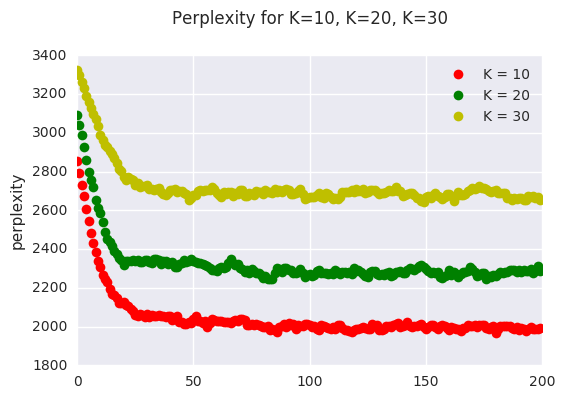

In [40]:
plt.plot(list(np.arange(200)),list(perp2), 'ro', color = 'r')
plt.plot(list(np.arange(200)),list(perp1), 'ro', color = 'g')
plt.plot(list(np.arange(200)),list(perp), 'ro', color = 'y')

plt.title('Perplexity for K=10, K=20, K=30', y=1.08)

plt.legend(['K = 10', 'K = 20', 'K = 30'], loc='upper right')

plt.ylabel('perplexity')
plt.show()

pass

$\quad$From the plot given above, we can see that after 100 iterations, perplexity did not vary a lot and $K = 10$ achieve the lowest perplexity. And we then chose $K = 10$, printed 10 most popular words for each topic and infered the news style of Associated Press. 

In [41]:
topicwords = []
maxTopicWordsNum = 10
for z in range(0, K):
    ids = np.array(zw_n_ap[z, :]).argsort()
    topicword = []
    for j in ids:
        topicword.insert(0, id_word_ap[j])
    topicwords.append(topicword[0 : min(10, len(topicword))])

In [42]:
top_words = pd.DataFrame(topicwords)

In [43]:
top_words

,0,1,2,3,4,5,6,7,8,9
0,said,bush,people,police,two,told,dukakis,get,one,back
1,said,officials,would,president,two,first,official,union,government,year
2,new,state,states,york,may,could,california,federal,global,summit
3,people,president,american,think,administration,good,trade,believe,public,country
4,central,southern,high,national,wednesday,got,front,fire,reported,record
5,said,new,million,also,bank,used,one,barry,jewish,east
6,soviet,years,gorbachev,many,union,rating,according,three,officers,system
7,former,defense,state,united,black,saudi,economic,washington,diplomatic,support
8,scientists,since,also,spacecraft,like,make,magellan,contact,called,group
9,percent,said,last,oil,rate,prices,company,rose,economy,year


$\quad$Here, each row in the dataframe above represents a topic. The first topic seems to be related to oil price. The second topic in AP may always make comparsion between New York and California. The third topic is about the union and immigration while the forth one is about justice system. Given these 10 topics we can infer that AP's news is mainly political news. More intereting experiment will be conducted in the furture!

### 7 Comparative analysis with Variational EM algorihtms

#### 7.1  Variational Inference

$\quad$In paper Latent Dirichlet Allocation(Blei, Ng and Jordan(2002)), the authors offered Variational Inference with EM algorithm as solution for computation difficulty of LDA.

distribution of latent variables:<br>
<center>$q(\vec{\theta},\vec{z} | \gamma,\vec{\phi}) = q(\vec{\theta} | \gamma) \prod_{n=1}^{N_i}q(z_n | \vec{\phi_n})$<br><center>

* $\gamma$: Dirichlet parameter for $\vec{\theta}$, variational parameter <br>
* $\vec{\phi}$: Multinomial parameter for $\vec{z}$ and can be denoted as $\phi_1$$\cdots$ $\phi_n$,free variatioanl parameter <br>

$\quad$We used Kullback-Leibler(KL) divergence to check the difference between latent distribution and true probability distribution. The value of KL divergence is always greater or equal to 0 and it is equal to 0 if and only if two distributions are same. Then we want to minimize the difference. Our goal is to find parameter <br>
* $\gamma^*$ and $\phi^*$ that minimize KL divergence using EM algorithm. <br>
<center>($\gamma^*$,$\phi^*$)=$\arg\min_{\gamma,\phi}
D(q(\vec{\theta},\vec{z} | \gamma,\vec{\phi}) || p(\vec{\theta},\vec{z} | \vec{w},\alpha,\beta))$<center>

**update $\vec{\phi}$**:<br>
<center>$\phi_{ni} \propto \beta_{iw_n}exp\{E_q[log(\theta_i)| \gamma]\}$<center>

* $E_q[log(\theta_i)| \gamma] = \Psi(\gamma_i) - \Psi(\sum_{j=1}^{k}\gamma_j)$<br>
* $\Psi$: the first derivative of log gamma (log $\Gamma$) function<br> 
<br>

**update $\vec{\gamma}$**:<br>
<center>$\gamma_i$ = $\alpha_i$ + $\sum_{n=1}^{N}$ $\phi_{ni}$<br>

#### 7.2 Pseudo code to calculate $\phi$ and $\gamma$ in Variational Inference
<quad> initialize $\phi_{ni}^0$: = 1/K for all i and n<br>
initialize $\gamma_i$: = $\alpha_i$ +N/k for all i<br>
repeat<br>
$\qquad$ for n = 1 to N<br>
$\qquad \quad$ for i = 1 to K<br>
$\qquad \qquad$ 
$\phi_{ni}^{t+1}$
:= $\beta_{iw_n}$exp($\Psi$($\gamma_i^t$))<br>
$\qquad \quad$ normalize 
$\phi_{n}^{t+1}$
to sum to 1<br>
$\qquad$ 
$\gamma^{t+1}$
: = $\alpha$ + $\sum_{n=1}^{N}$ $\phi_{ni}^{t+1}$<br>
until convergence<br>

#### Packages Installation

In [44]:
from scipy.special import psi
import math

#### 7.3 Data Cleaning Function(EM)

In [45]:
def text_processor_em(documents):
    
    """
    Split and filter words for each document in corpus.
    Create VOCABULARY and word-id table

    Parameters
    ----------
    corpus          : a valid address of text file and each line in this file
    represents a document

    Returns
    -------
    wordID          : a list with 16 lists inside
                      every list repersents index of a word in the document
                      
    Countword       : a list with 16 lists inside
                      every list represents the number of the word in the document
                      
    singlecount     : a list with 16 lists inside
                      every list represents the number of total words in the document
                      
    word_id         : a dictionary 
                      takes vocabulary of corpus as keys and a set of unique 
                      numbers as values
    
    id_word         : a dictionary
                      takes a set of unique numbersas keys and vocabulary of 
                      corpus as values
               
    """
    
    
    
    
    stopWords = set(nltk.corpus.stopwords.words('english'))

    articles = []
    word_id = {}
    id_word = {}
    current_wordid = 0
    wordID = []
    Countword = []
    singlecount = [] 
    store1 = []
    store2 = []
    for doc in documents:
        word_count = {}
            ## split words
        word_split = doc.split()
        for word in word_split:
            word = word.lower().strip()
            ##
            if (len(word)) > 1 and  word.isalpha() and word not in stopWords:
                if word not in word_id:
                    word_id[word] = current_wordid
                    id_word[current_wordid] = word
                    current_wordid += 1
                if word in word_count:
                    word_count[word] += 1
                else:
                    word_count[word] = 1
                
        wordIDList = []
        wordCountList = []
        wordCount = 0

        for word in word_count.keys():
            wordIDList.append(word_id[word])
            wordCountList.append(word_count[word])
            wordCount = wordCount + word_count[word] #total words in a doc
        wordID.append(wordIDList)
        Countword.append(wordCount)
        singlecount.append(wordCountList)
        store1.append(wordIDList)
        store1.append(wordCountList)
        store1.append(wordCount)    
        store1 = []
        store2.append(store1)
    return wordID,Countword,singlecount,word_id,id_word

#### 7.4 Initialization and EM algorithm

In [46]:
def maxwordnum():
    """
    count length of lengest document 

    Parameters
    ----------
    
    Returns
    -------
    max(length)          : the lengest length of a document
                
    """
    
    length = []
    for l in wordID:
        length.append(len(l))
    return max(length)   

In [47]:
def initial():
    """
    initialize the model

    Parameters
    ----------
    
    Returns
    -------
    updatebeta            : a matrix
                            updated ny ntw and nt matrix
                
    """
    
    for z in range(0, K):
        for w in range(0, N):
            ntw[z, w] += 1.0/N + np.random.random() # probabily of word under every topic
            nt[z] += ntw[z, w] 
    updatebeta(beta,K,N, ntw, nt)

In [48]:
%%cython

import cython
cimport numpy as np
import numpy as np
from libc.math cimport log
cimport scipy.special.cython_special
from scipy.special.cython_special import psi


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def updatebeta(double[:,:] beta, int K,int N, double[:,:] ntw, double[:] nt):
    
    """
    update beta matrix 

    Parameters
    ----------
    beta          : A matrix,
                    return value from initial method
                           
    K             : number of topics 
    N             : length of words
    ntw           : topic-words distribution
    nt            : words distribution under one topic 
    
    
    Returns
    -------
    beta          : updated matrix
                
    """
    
    
    cdef int z,w
    for z in range(0,K):
        for w in range(0,N):
            if(ntw[z,w] > 0):
                beta[z,w] = beta[z,w] = log(ntw[z,w] / nt[z])
            else:
                beta[z,w] = -100

In [49]:
%%cython

import cython
cimport numpy as np
import numpy as np
from libc.math cimport exp,log
cimport scipy.special.cython_special
from scipy.special.cython_special import psi


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def variational(double[:,:] gamma, double[:,:] phi, singlecount,wordID, Countword, double[:,:] beta,
                int alpha, int d, int K, int infer_iter):
    """
    Variational with E step
    
    Parameters
    ----------
    gamma         : a matrix, shape(M,K), latent parameter of a distribution of topic for each document
    phi           : a matrix, shape(K,v), latent parameter of a distribution of words for each topic
    wordID        : a list returned by text_processor method
    Countword     : a list returned by text_processor method
    beta          : a matrix, returned by initial method
    alpha         : a fix number 
    d             : a fix number 
    K             : number of topics, a fix number
    infer_iter    : number of iteration
    
    Returns
    -------gamma
    gamma         : updated gamma, a matrix, shape(M,K), distribution of topic for each document
   
   """

    cdef int wordlength = len(wordID[d])
    cdef double totalphi = 0
    cdef double[:] phi_old = np.zeros((K))
    cdef double [:] gamma_prime = np.zeros((K))
    cdef int z, iteration,w

    # initialize parameter
    for z in range(K):
        #initialize gamma
        gamma[d][z] = alpha + Countword[d] * 1.0 / K
        gamma_prime[z] = psi(gamma[d][z])
        # initialize phi
        for w in range(0,len(wordID[d])):
            phi[w,z] = 1.0 / K
    
    for iteration in range(infer_iter):
        for w in range(wordlength):
            totalphi = 0
            for z in range(0,K):
                phi_old[z] = phi[w,z]
                phi[w,z] = beta[z,wordID[d][w]] + gamma_prime[z]
                if z > 0:
                    totalphi = log((exp(totalphi)) + exp(phi[w,z]))
                else:
                    totalphi = phi[w,z]
            for z in range(0,K):
                phi[w,z] = exp(phi[w,z] - totalphi)
                gamma[d][z] = gamma[d][z] + singlecount[d][w] * (phi[w,z] - phi_old[z])
                gamma_prime[z] = psi(gamma[d][z]) 
                
    return gamma

#### 7.5 EM Algorithm Test

In [50]:
wordID,Countword,singlecount,word_id,id_word = text_processor_em(test_list)

In [51]:
M = len(wordID)
K = 2
N = len(word_id)
infer_iter = 20
EM_iter = 50
# inital value for hyperparameter alpha
alpha = 5
# sufficient statistic of alpha
alphass = 0 
# topic-word distribution
beta = np.zeros((K,N))
# topic count, to caculate beta
ntw = np.zeros((K,N))
# topic count, sum of ntw, to calculate beta
nt = np.zeros((K))
# variational inference parameter 
gamma = np.zeros((M,K))
phi = np.zeros((maxwordnum(),K))

In [52]:
initial()

In [53]:
for iteration in range(0,EM_iter):
    nt = np.zeros((K))
    ntw = np.zeros((K,N))
    alphass = 0
    
        # E step
    for d in range(0,M):
        variational(gamma, phi, singlecount,wordID, Countword, beta, alpha, d, K, infer_iter)
        totalgamma = 0
        for z in range(0,K):
            totalgamma += gamma[d,z]
            alphass += psi(gamma[d,z])
        alphass -= K * psi(totalgamma)
        
        for w in range(len(wordID[d])):
            for z in range(0,K):
                ntw[z][wordID[d][w]] += singlecount[d][w] * phi[w,z]
                nt[z] += singlecount[d][w] * phi[w,z]
    # M step
    updatebeta(beta,K,N, ntw, nt)

In [54]:
gamma/np.sum(gamma,1)[:,None]

array([[ 0.71447998,  0.28552002],
       [ 0.20566964,  0.79433036]])

$\quad$Here, we apply implementation of LDA with Variatioal Inference EM on our simulation data. The true topics distribution is as below. Under document 1, one topic has 30% to be assigned and the other topic has 70% to be assigned. Under document1, one topic has around 80% probability and another topic has around 20% probability. The EM algorithm produces a similar result, which for document one, one topic has 28.6 % to be assigned and other topic has 71.4% to be assigned. For document2, one topic has 79.5% to be assigned and other has 20.5%. So the result is highly similar to the true document-topics distribution, which proves the validality of the algorithm.  

#### 7.6 Perplexity Comparison Gibbs Sampler vs Variational EM

In [55]:
wordID,Countword,singlecount,word_id,id_word = text_processor_em(docs_ap)

In [56]:
M = len(wordID)
K = 10
N = len(word_id)
infer_iter = 20
EM_iter = 20
alpha = 5
alphass = 0 
beta = np.zeros((K,N))
ntw = np.zeros((K,N))
nt = np.zeros((K))
gamma = np.zeros((M,K))
phi = np.zeros((maxwordnum(),K))

In [57]:
initial()

In [58]:
perp = []
for iteration in range(0,EM_iter):
    nt = np.zeros((K))
    ntw = np.zeros((K,N))
    alphass = 0
    
        # E step
    for d in range(0,M):
        variational(gamma, phi, singlecount,wordID, Countword, beta, alpha, d, K, infer_iter)
        totalgamma = 0
        for z in range(0,K):
            totalgamma += gamma[d,z]
            alphass += psi(gamma[d,z])
        alphass -= K * psi(totalgamma)
        
        for w in range(len(wordID[d])):
            for z in range(0,K):
                ntw[z][wordID[d][w]] += singlecount[d][w] * phi[w,z]
                nt[z] += singlecount[d][w] * phi[w,z]
    # M step
    updatebeta(beta,K,N, ntw, nt)
    
    # perplexity
    nd = np.sum(np.array(gamma),1)
    n = 0
    ll = 0.0

    for d,doc in enumerate(wordID):
        for w in doc:
            ll = ll + np.log(((np.array(ntw)[:, w] / np.array(nt))* (np.array(gamma)[d, :] / nd[d])).sum())
            n = n + 1
            exp_ll = np.exp(ll/(-n))
    perp.append(exp_ll) 

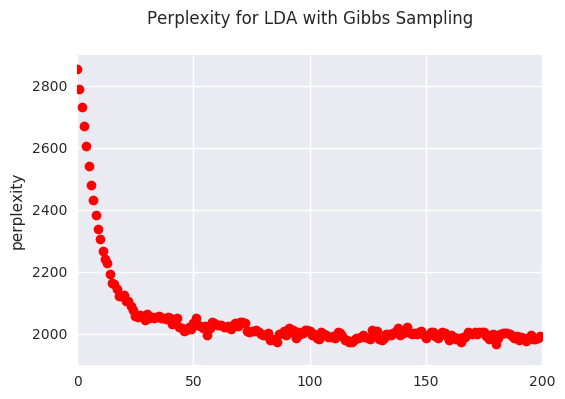

In [59]:
plt.plot(list(np.arange(200)),list(perp2), 'ro', color = 'r')

plt.title('Perplexity for LDA with Gibbs Sampling', y=1.08)

plt.ylabel("perplexity")

pass

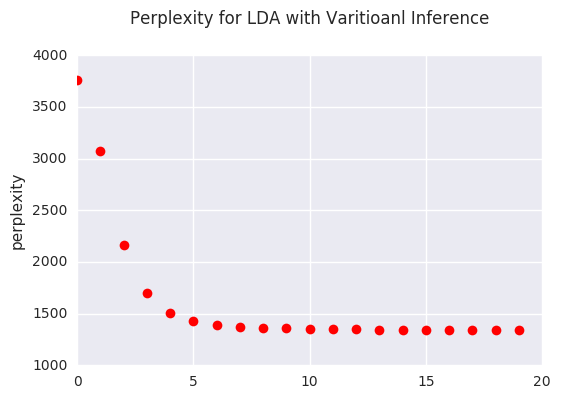

In [60]:
plt.plot(list(np.arange(20)),list(np.array(perp)), 'ro', color = 'r')

plt.title('Perplexity for LDA with Varitioanl Inference', y=1.08)

plt.ylabel("perplexity")
pass

$\quad$ This part we compare perplexity of LDA implemented with Gibbs Sampler and with Variational Inference EM algorithm. We apply these two algorithms on `dataset2.txt`. From the plots, we can see that the perplexity of LDA with Gibbs Sampler is really high, around 3000, and it converges around 2000 after 50 iterations. The perplexity of LDA with Variational Inference EM starts with around 3700 but covnerge to around 1300 soon after around 10 iterations. So from perplexity, LDA with EM algorithm performs better than Gibbs Sampler. 

#### 7.6 Efficiency Comparison Gibbs Sampler vs Variational EM

In [61]:
%timeit dz_n_apt,zw_n_apt,z_n_apt,perp_apt = gibbs_sampler_cython(200, articles_ap,Z_ap,dz_n_ap,zw_n_ap,z_n_ap,K_ap)

1 loop, best of 3: 5.09 s per loop


In [62]:
%%timeit
for iteration in range(0,5):
    nt = np.zeros((K))
    ntw = np.zeros((K,N))
    alphass = 0
    
        # E step
    for d in range(0,M):
        variational(gamma, phi, singlecount,wordID, Countword, beta, alpha, d, K, infer_iter)
        totalgamma = 0
        for z in range(0,K):
            totalgamma += gamma[d,z]
            alphass += psi(gamma[d,z])
        alphass -= K * psi(totalgamma)
        
        for w in range(len(wordID[d])):
            for z in range(0,K):
                ntw[z][wordID[d][w]] += singlecount[d][w] * phi[w,z]
                nt[z] += singlecount[d][w] * phi[w,z]
    # M step
    updatebeta(beta,K,N, ntw, nt)

1 loop, best of 3: 28 s per loop


$\quad$ This part we compare efficiency of LDA implemented with Gibbs Sampler and with Variational Inference EM algorithm. The first time showed is time of Gibbs Sample process, while the second time showed is time of EM algorithm. Gibbs Sampler is obvious faster than EM algorithm. So from efficiency, Gibbs Sampler perfoms better. 

### 8 Conclusion

$\quad$ LDA is a three-level hierarchical Bayesian model to deal with text data. It is a used approach in unsuper vised machine learning. It performs better than pLSI. The pLSI posits each word of training document comes from a random chosen topic. So the topics are randomly drawed from one specific document. There is only one distribution of topics under a document. However in LDA, document is not fixed, it is also sampled with a parameter. So, LDA is more flexible. LDA has been applied widely for text data. It can achieve document modeling, document classification, and collaborative filtering. We implemented LDA with Gibbs Sampler and Variational Inference. We apply LDA on corpus to find the most popular words under topics. Also it can be used to find latent topics behind documents. To copmare these two algorithms, Variational Inference does well in perplexity while Gibbs Sampler performs better in efficiency.

### 9 Reference

[1] David M Blei, Andrew Y Ng, and Michael I Jordan. Latent dirichlet allocation. Journal of
Machine Learning Research, 3:993–1022, 2003.

[2] Associated Press, address https://en.wikipedia.org/wiki/Associated_Press

[3]zhikaizhang, address https://github.com/laserwave/LDA-Variational-EM